In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import biom
import logging
import collections
from tqdm import tqdm
import scipy

from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import Dictionary

#FILE_OTU = '/home/psadow/lts/shared/microbiome/waimea/09_15_2020/16S/Processed/rel_abund_MM_16S_otu_table.csv'
#FILE_SAMPLE = '/home/psadow/lts/shared/microbiome/waimea/09_15_2020/16S/Processed/rel_abund_MM_16S_sample_data.csv'
FILE_OTU = './data/rel_abund_MM_16S_otu_table.csv'
FILE_SAMPLE = './data/rel_abund_MM_16S_sample_data.csv'

def get_corpus(file_otu, file_sample):
    """
    Read data and represent it as a 'corpus' analagous to a collection of documents.
    """
    df = pd.read_csv(file_otu, index_col=0) # 5747 OTUs by 1410 samples
    df = (df * 10000).astype(int) # Processed data is subsampled to 10k and converted to relative abundance.
    samples = pd.read_csv(file_sample, index_col=0)  # 1410 samples by 54 features
    
    # Create corpus. 
    corpus = []
    for sample in tqdm(df.columns):
        doc = []
        for otu, count in zip(df.index, df[sample]):
            doc.extend([otu]*count) # Inefficient as hell, but couldn't figure other way to use gensim.Dictionary.
        corpus.append(doc)

    dct = Dictionary(corpus)
    print(dct.num_docs, dct.num_nnz, dct.num_pos, len(dct.token2id)) #(1646, 1732685, 127704384, 257910)
    dct.filter_extremes(no_below=10, no_above=0.5)
    print(dct.num_docs, dct.num_nnz, dct.num_pos, len(dct.token2id)) # (1646, 1732685, 127704384, 35118)
    temp = dct[0]  # This is only to "load" the dictionary for dct.id2token.
    corpus_bow = [dct.doc2bow(sample) for sample in corpus] # Convert to Bag of Words (bow) representation.
    return dct, corpus_bow, df

def get_topics(model, dct):
    '''
    Get topics as distribution of asvs. Column 1 are asvs. Other columns are PMFs over these asvs, one for each topic.
    Returns:
    df: pandas dataframe with col1 asv string, then 20 cols representing topics.
    '''
    num_asvs = len(dct.id2token)
    assert num_asvs == model.num_terms
    m = model.get_topics() # (20, 35118)
    asv_list = [dct.id2token[i] for i in range(m.shape[1])]
    df = pd.DataFrame(data=m.T, index=asv_list)
    return df

def per_sample_topics(model, dct, corpus_bow, df):
    '''
    Returns:
    pmfs: num_samples x num_topics numpy array, where i,j is i sample j topic.
    '''
    sample_ids = df.columns
    num_samples = len(corpus_bow)
    assert num_samples == len(sample_ids)
    pmfs = np.zeros((num_samples, model.num_topics)) 
    for i,sample in enumerate(corpus_bow):
        tuples = model.get_document_topics(sample) # Get topic probability distribution for a document.
        # tuples = list(sorted(tuples, key=lambda x: x[1], reverse=True))
        #pmf = [t[1] for t in tuples]
        for topic, p in tuples:
            pmfs[i, topic] = p
    rval = pd.DataFrame(data=pmfs, index=sample_ids)
    return rval

# Logging suggested for LDAModel in https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 

# Load data.
dct, corpus_bow, df = get_corpus(FILE_OTU, FILE_SAMPLE)

100%|██████████| 1410/1410 [00:02<00:00, 548.31it/s]
2020-11-30 09:10:13,639 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-11-30 09:10:15,150 : INFO : built Dictionary(5747 unique tokens: ['Otu000005', 'Otu000012', 'Otu000044', 'Otu000048', 'Otu000069']...) from 1410 documents (total 14065618 corpus positions)
2020-11-30 09:10:15,155 : INFO : discarding 2069 tokens: [('Otu000012', 842), ('Otu013552', 5), ('Otu019917', 1), ('Otu053473', 4), ('Otu014653', 7), ('Otu065779', 3), ('Otu018637', 8), ('Otu035207', 3), ('Otu000026', 732), ('Otu010522', 9)]...
2020-11-30 09:10:15,155 : INFO : keeping 3678 tokens which were in no less than 10 and no more than 705 (=50.0%) documents
2020-11-30 09:10:15,158 : INFO : resulting dictionary: Dictionary(3678 unique tokens: ['Otu000005', 'Otu000044', 'Otu000048', 'Otu000069', 'Otu000072']...)


1410 224498 14065618 5747
1410 224498 14065618 3678


In [7]:
# Create topic otu distributions. The first column contains the otu names. The next 20 columns contain the distributions over OTUs for each topic. 
topic_otus = get_topics(model, dct)
topic_otus.to_csv(f'{num_topics}topics_topic_otus.csv', header=False)

# Create sample_topics. Each row is the sample name, followed by the fraction of the sample attributed to each of 20 topics.
sample_topics = per_sample_topics(model, dct, corpus_bow, df)
sample_topics.to_csv(f'{num_topics}topics_sample_topics.csv', header=False)
print('File output shapes:', topic_otus.shape, sample_topics.shape)

File output shapes: (3678, 1000) (1410, 1000)


In [3]:
# Train on microbiome dataset.
num_topics = 1000 
model = LdaModel( # LdaMulticore(workers=4,
            corpus_bow, random_state=42,
            num_topics=num_topics,
            chunksize = 2000, #id2word=dct.id2token,
            alpha='auto', eta='auto', # Requires LDAModel
            passes=500, iterations=100, eval_every=1) 
model.save(f'{num_topics}topics_model.lda')

# Example code for examining topics.
# model.show_topics(num_words=3, formatted=False)

# Create topic otu distributions. The first column contains the otu names, 
# followed by num_topics columns with the distributions over OTUs for each topic. 
topic_otus = get_topics(model, dct)
topic_otus.to_csv(f'{num_topics}topics_topic_otus.csv', header=False)

# Create sample-level topic distributions. Each row is the sample name,
# followed by the fraction of the sample attributed to each of 20 topics.
sample_topics = per_sample_topics(model, dct, corpus_bow, df)
sample_topics.to_csv(f'{num_topics}topics_sample_topics.csv', header=False)
print('File output shapes:', topic_otus.shape, sample_topics.shape)

2020-11-29 15:51:32,229 : WARNING : no word id mapping provided; initializing from corpus, assuming identity
2020-11-29 15:51:32,246 : INFO : using autotuned alpha, starting with [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0

NameError: name 'dct' is not defined

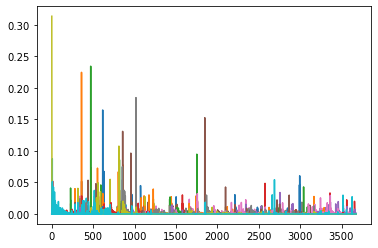

In [44]:
# Plot distribution of OTUs in each topic. 
x = topic_otus.to_numpy()
plt.plot(x)

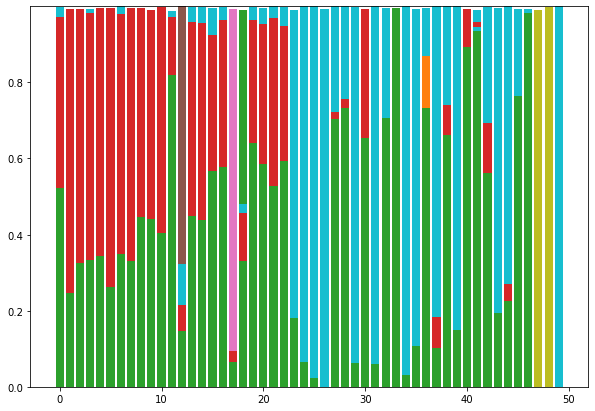

In [58]:
# Plot distribution of topics in each sample. 
N = 50 # First N samples
x = sample_topics.to_numpy()
fig, ax = plt.subplots(figsize=(10,7))  
margin_bottom = np.zeros(N)
for i in range(x.shape[1]):
    values = x[:N, i]
    plt.bar(x=np.arange(N),height=values, bottom = margin_bottom)
    margin_bottom += values
plt.show()